# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import json
%matplotlib inline

# Used to ignore some warnings for sns
import warnings 
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Inspect the Data

### Inspect portfolio data

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [6]:
portfolio['channels'].value_counts(), portfolio['offer_type'].value_counts(), portfolio['reward'].value_counts()

(channels
 [web, email, mobile, social]    4
 [web, email, mobile]            3
 [email, mobile, social]         2
 [web, email]                    1
 Name: count, dtype: int64,
 offer_type
 bogo             4
 discount         4
 informational    2
 Name: count, dtype: int64,
 reward
 5     3
 10    2
 0     2
 2     2
 3     1
 Name: count, dtype: int64)

### Inspect profile data

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# Count null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Gender and income are missing for some customers. We will drop these customers from our analysis in the next section.

In [12]:
profile.shape

(17000, 5)

In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


### Inspect transcript data

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.shape

(306534, 4)

In [16]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

## 2. Data Cleaning

### Clean and preprocess portfolio data

In [19]:
# Get dummy variables for channels column
portfolio_channel_dummies = pd.get_dummies(portfolio['channels'].explode(), dtype=int).groupby(level=0).sum()
portfolio_channel_dummies

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [20]:
# Get dummy variables for offer_type column
portfolio_offer_dummies = pd.get_dummies(portfolio['offer_type'], dtype=int)
portfolio_offer_dummies

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [21]:
clean_portfolio = pd.concat([portfolio, portfolio_channel_dummies, portfolio_offer_dummies], axis=1) # concat dummy variables to portfolio dataframe
clean_portfolio = clean_portfolio.drop(['channels', 'offer_type'], axis=1) # drop channels and offer_type columns
clean_portfolio

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


### Clean and preprocess profile data

In [22]:
# Count null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [23]:
# Since the null values for the gender and income columns are the same, we can assume that the same rows have null values for both column and drop them
clean_profile =  profile.dropna()
clean_profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


### Clean and preprocess transcript data

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [25]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [121]:
# Remove transaction event rows
clean_transcript =  transcript[transcript['event'] != 'transaction']

# Extract the rows that are related to the event
clean_transcript = clean_transcript[clean_transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

# Extract the offer id from value column
clean_transcript['offer_id'] = clean_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

# Drop the value column
clean_transcript = clean_transcript.drop('value', axis=1)

clean_transcript

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4


## 3. Exploratory Data Analysis

**What is the gender distribution?**

In [28]:
clean_profile['gender'].value_counts().values

array([8484, 6129,  212], dtype=int64)

Text(0, 0.5, 'Count')

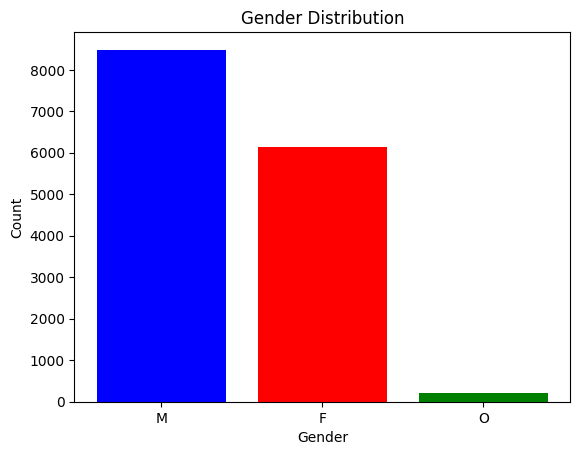

In [29]:
plt.bar(clean_profile['gender'].value_counts().index, clean_profile['gender'].value_counts().values, color=['Blue', 'Red', 'Green'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

There are more male than female and other customers in the study. There are 8484 men, 6129 female and 212 other customers.

**How is income distributed among gender in the dataset, comparing male and female?**

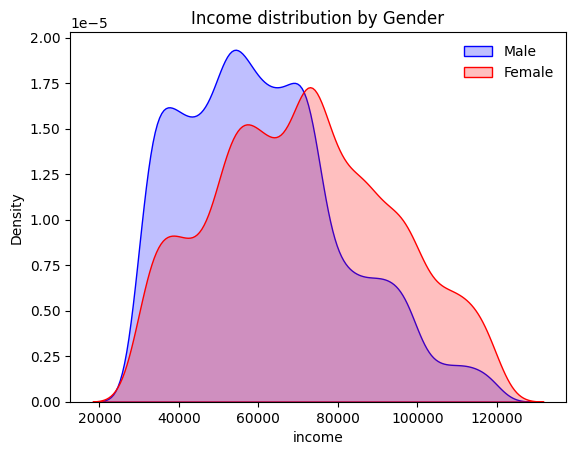

In [30]:
sns.distplot(profile[profile['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Income distribution by Gender')
plt.legend(['Male','Female'],frameon=False)

**How is age distributed among gender in the dataset, comparing male and female?**

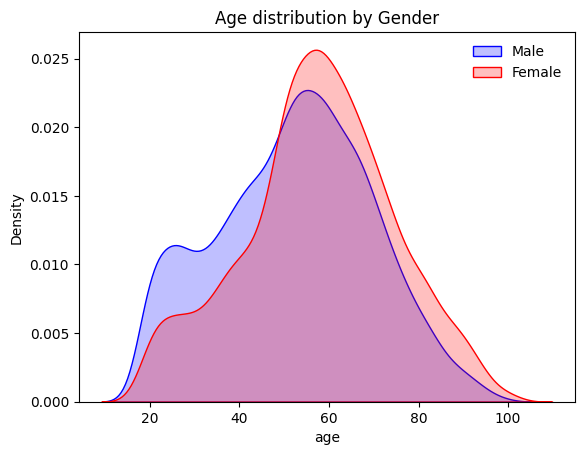

In [31]:
sns.distplot(clean_profile[profile['gender']=='M']['age'],hist=False,color="b", kde_kws={"shade": True})
sns.distplot(clean_profile[profile['gender']=='F']['age'],hist=False,color="r", kde_kws={"shade": True})
plt.title('Age distribution by Gender')
plt.legend(['Male','Female'],frameon=False)

## 4. Create user-item matrix

In [122]:
clean_transcript

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4


In [130]:
def create_user_item_matrix(clean_transcript, filename):
    '''
    Return the user item matrix that indicate the number of offers completed by a user
    
    INPUT:
    clean_transcript - a cleaned transcript dataframe
    filename - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offers completed by the user (NaN means no offer given)
    
    The matrix is written to a pickle file
    '''

    # Create an empty user-item matrix
    user_item_matrix = clean_transcript.groupby(['person', 'offer_id'])['event'].count().unstack().map(lambda x: np.nan)
    # Drop informational offers because they only have views and no completion
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)

    for offer_id in user_item_matrix.columns: # iterate through each offer
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index: # iterate through each user
            num += 1
            if num % 1000 == 0:
                print("Finished ", np.round(num/user_item_matrix.shape[0]*100), '%')
            events = []
            for event in clean_transcript[(clean_transcript['offer_id']==offer_id) & (clean_transcript['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # Check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # If yes, we assume the user reacted positively with the offer we provided
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0

    # Write the user item matrix to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(user_item_matrix, f)

    return user_item_matrix

In [123]:
#Set the traning test split to 70:30
train_size = int(clean_transcript.shape[0]*0.7)
test_size = clean_transcript.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [124]:
train_transcript = clean_transcript.iloc[:train_size, :]
test_transcript = clean_transcript.iloc[train_size:, :]

In [125]:
train_transcript.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [126]:
test_transcript.head()

,person,event,time,offer_id
209139,ee17ec3543154db188a6afa0d74b7e9f,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9
209140,b148b540df8c4aa5a8a0b79be4fdecbe,offer received,504,5a8bc65990b245e5a138643cd4eb9837
209141,cbd9b4ad54a8422c82004fd4e8d8d746,offer received,504,0b1e1539f2cc45b7b9fa7c272da2e1d7
209142,54ac605ec4354bbfa726012d5236f4a1,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9
209143,0a68034a1858477e8053ca18a05c213c,offer received,504,4d5c57ea9a6940dd891ad53e9dbe8da0


In [131]:
# Took 50 minutes to run
# complete_user_item_matrix = create_user_item_matrix(clean_transcript, 'data/complete_user_item_matrix.pkl')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished  6.0 %
Finished  12.0 %
Finished  18.0 %
Finished  24.0 %
Finished  29.0 %
Finished  35.0 %
Finished  41.0 %
Finished  47.0 %
Finished  53.0 %
Finished  59.0 %
Finished  65.0 %
Finished  71.0 %
Finished  76.0 %
Finished  82.0 %
Finished  88.0 %
Finished  94.0 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished  6.0 %
Finished  12.0 %
Finished  18.0 %
Finished  24.0 %
Finished  29.0 %
Finished  35.0 %
Finished  41.0 %
Finished  47.0 %
Finished  53.0 %
Finished  59.0 %
Finished  65.0 %
Finished  71.0 %
Finished  76.0 %
Finished  82.0 %
Finished  88.0 %
Finished  94.0 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
Finished  6.0 %
Finished  12.0 %
Finished  18.0 %
Finished  24.0 %
Finished  29.0 %
Finished  35.0 %
Finished  41.0 %
Finished  47.0 %
Finished  53.0 %
Finished  59.0 %
Finished  65.0 %
Finished  71.0 %
Finished  76.0 %
Finished  82.0 %
Finished  88.0 %
Finished  94.0 %
Now processing:  4d5c57ea9a6940dd891a

In [ ]:
# Get user item matrix from pickle file instead of running the function again
with open('data/complete_user_item_matrix.pkl', 'rb') as f:
    complete_user_item_matrix = pickle.load(f)

In [132]:
complete_user_item_matrix.shape

(16994, 8)

In [134]:
# Took 35 minutes to run
# train_user_item_matrix = create_user_item_matrix(train_transcript, 'data/train_user_item_matrix.pkl')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished  6.0 %
Finished  12.0 %
Finished  18.0 %
Finished  24.0 %
Finished  29.0 %
Finished  35.0 %
Finished  41.0 %
Finished  47.0 %
Finished  53.0 %
Finished  59.0 %
Finished  65.0 %
Finished  71.0 %
Finished  77.0 %
Finished  83.0 %
Finished  88.0 %
Finished  94.0 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished  6.0 %
Finished  12.0 %
Finished  18.0 %
Finished  24.0 %
Finished  29.0 %
Finished  35.0 %
Finished  41.0 %
Finished  47.0 %
Finished  53.0 %
Finished  59.0 %
Finished  65.0 %
Finished  71.0 %
Finished  77.0 %
Finished  83.0 %
Finished  88.0 %
Finished  94.0 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
Finished  6.0 %
Finished  12.0 %
Finished  18.0 %
Finished  24.0 %
Finished  29.0 %
Finished  35.0 %
Finished  41.0 %
Finished  47.0 %
Finished  53.0 %
Finished  59.0 %
Finished  65.0 %
Finished  71.0 %
Finished  77.0 %
Finished  83.0 %
Finished  88.0 %
Finished  94.0 %
Now processing:  4d5c57ea9a6940dd891a

In [ ]:
# Get user item matrix from pickle file instead of running the function again
with open('data/train_user_item_matrix.pkl', 'rb') as f:
    train_user_item_matrix = pickle.load(f)

In [135]:
train_user_item_matrix.shape

(16955, 8)

In [136]:
# Took 15 minutes to run
# test_user_item_matrix = create_user_item_matrix(test_transcript, 'data/test_user_item_matrix.pkl')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Finished  6.0 %
Finished  13.0 %
Finished  19.0 %
Finished  25.0 %
Finished  32.0 %
Finished  38.0 %
Finished  44.0 %
Finished  51.0 %
Finished  57.0 %
Finished  63.0 %
Finished  69.0 %
Finished  76.0 %
Finished  82.0 %
Finished  88.0 %
Finished  95.0 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Finished  6.0 %
Finished  13.0 %
Finished  19.0 %
Finished  25.0 %
Finished  32.0 %
Finished  38.0 %
Finished  44.0 %
Finished  51.0 %
Finished  57.0 %
Finished  63.0 %
Finished  69.0 %
Finished  76.0 %
Finished  82.0 %
Finished  88.0 %
Finished  95.0 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
Finished  6.0 %
Finished  13.0 %
Finished  19.0 %
Finished  25.0 %
Finished  32.0 %
Finished  38.0 %
Finished  44.0 %
Finished  51.0 %
Finished  57.0 %
Finished  63.0 %
Finished  69.0 %
Finished  76.0 %
Finished  82.0 %
Finished  88.0 %
Finished  95.0 %
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Finished  6.0 %
Finished  13.0 %
Finis

In [105]:
# Get user item matrix from pickle file instead of running the function again
with open('data/test_user_item_matrix.pkl', 'rb') as f:
    test_user_item_matrix = pickle.load(f)

,person,event,time,offer_id,reward
209139,ee17ec3543154db188a6afa0d74b7e9f,offer received,504,NaN,NaN
209140,b148b540df8c4aa5a8a0b79be4fdecbe,offer received,504,NaN,NaN
209141,cbd9b4ad54a8422c82004fd4e8d8d746,offer received,504,NaN,NaN
209142,54ac605ec4354bbfa726012d5236f4a1,offer received,504,NaN,NaN
209143,0a68034a1858477e8053ca18a05c213c,offer received,504,NaN,NaN
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,NaN,NaN
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,NaN,NaN
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,NaN,NaN
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,NaN,NaN


In [137]:
test_user_item_matrix.shape

(15828, 8)